In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator
from notebook_utils import configure_path, setup_matplotlib

In [2]:
configure_path()
setup_matplotlib()

## The Role of CANTV

The history of CANTV provides a valuable perspective for understanding the role of the Venezuelan state in the country’s telecommunications market. The company known as Compañía Anónima Nacional Teléfonos de Venezuela, commonly referred to as CANTV, has changed ownership multiple times throughout its history. Initially established as a private company in 1930, it underwent its first nationalization in 1953. Subsequently, it was privatized once more in 1991 and then re-nationalized during the administration of President Hugo Chávez in 2007.

Over the past two decades, CANTV has continuously announced the largest portion of Venezuela’s address space. To illustrate its dominance, we conduct an analysis of the allocated address space in Venezuela and the visibility of these prefixes on BGP collectors. To that end, we download snapshots of CAIDA’s AS prefix-to-AS files (https://www.caida.org/catalog/datasets/routeviews-prefix2as) and LACNIC delegation files (https://ftp.lacnic.net/pub/stats/lacnic) collected on the first of each month since 2008 to examine the structure of Venezuela’s allocated and announced address space over time. We compare the footprint of CANTV with that of its closest peer, Telefonica de Venezuela (also known as Movistar, AS6303), the local subsidiary of the homonymous Spanish conglomerate.

In [3]:
# Local Utils
def castdt(t):
    return datetime.strptime(t, "%Y-%m-%d")

In [4]:
addr_space = pd.read_csv(
    "data/processed/02-addr-space/02-addr_space_ve.csv.gz", compression="gzip"
)
addr_space = addr_space.loc[~addr_space["origin-asn"].str.contains("\.")]
addr_space["origin-asn"] = addr_space["origin-asn"].astype(int)
addr_space["date"] = addr_space["date"].map(castdt)

In [5]:
addr_space.head()

,cc,origin-asn,ip-cnt,date
0,VE,3496,204800,2008-03-01
1,VE,20312,262144,2008-03-01
2,VE,19192,73984,2008-03-01
3,VE,23007,51200,2008-03-01
4,VE,8048,1574912,2008-03-01


In [6]:
l = []
for asn in addr_space.drop_duplicates("origin-asn")["origin-asn"].values:

    t = addr_space.loc[addr_space["origin-asn"] == asn]["date"].values
    x = addr_space.loc[addr_space["origin-asn"] == asn]["ip-cnt"].values
    c = (
        addr_space.loc[addr_space["date"].isin(t)]
        .groupby("date")["ip-cnt"]
        .sum()
        .reset_index()["ip-cnt"]
        .values
    )

    l.append((asn, (x / c).max()))

In [7]:
max_addr_space = pd.DataFrame(l, columns=["asn", "max_frac"])

In [8]:
max_addr_space.sort_values("max_frac")

,asn,max_frac
94,100,0.000031
99,354952386,0.000041
236,8053267701,0.000041
233,269984,0.000041
70,65000,0.000042
...,...,...
0,3496,0.077624
41,27889,0.080566
1,20312,0.099359
25,6306,0.315527


In [9]:
label_dict = {
    8048: "CANTV-AS8048",
    6306: "Telefonica-AS6306",
}

8048 0.43 0.69
6306 0.01 0.32


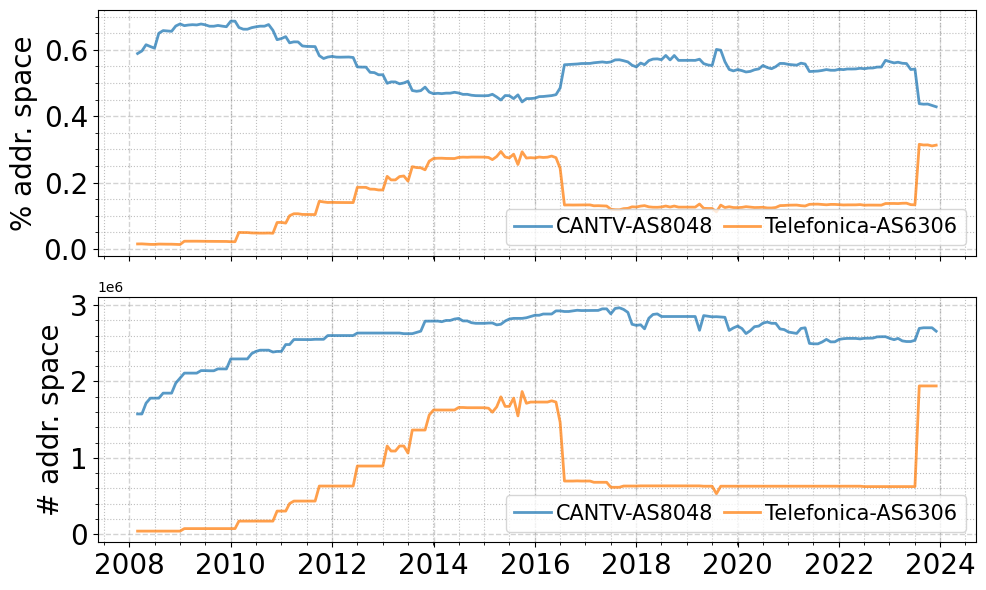

In [10]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

for asn in [8048, 6306]:
    t = addr_space.loc[addr_space["origin-asn"] == asn]["date"].values
    x = addr_space.loc[addr_space["origin-asn"] == asn]["ip-cnt"].values
    c = (
        addr_space.loc[addr_space["date"].isin(t)]
        .groupby("date")["ip-cnt"]
        .sum()
        .reset_index()["ip-cnt"]
        .values
    )

    ax1.plot_date(
        t,
        x / c,
        xdate=True,
        ydate=False,
        tz="UTC",
        alpha=0.75,
        lw=2,
        fmt="-",
        marker="None",
        label=f"{label_dict[asn]}",
    )

    print(asn, f"{(x / c).min():.02f}", f"{(x / c).max():.02f}")

    ax2.plot_date(
        t,
        x,
        xdate=True,
        ydate=False,
        tz="UTC",
        alpha=0.75,
        lw=2,
        fmt="-",
        marker="None",
        label=f"{label_dict[asn]}",
    )


ax1.set_ylabel("% addr. space", fontsize=20)
ax1.tick_params(labelsize=20)
ax1.legend(
    loc="lower right",
    ncol=2,
    frameon=True,
    fontsize=15,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax1.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax1.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax1.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax1.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())

ax2.set_ylabel("# addr. space", fontsize=20)
ax2.tick_params(labelsize=20)
ax2.legend(
    loc="lower right",
    ncol=2,
    frameon=True,
    fontsize=15,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax2.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax2.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax2.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax2.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/02-addr_space.pdf")

In [11]:
r = []

# Get the minimum gap between the two ASNs
for asn in [8048, 6306]:
    t = addr_space.loc[addr_space["origin-asn"] == asn]["date"].values
    x = addr_space.loc[addr_space["origin-asn"] == asn]["ip-cnt"].values
    c = (
        addr_space.loc[addr_space["date"].isin(t)]
        .groupby("date")["ip-cnt"]
        .sum()
        .reset_index()["ip-cnt"]
        .values
    )
    r.append(x / c)

(r[0] - r[1]).min()

0.11556876341423145

The figure shows the fraction and the total address space held by both companies. CANTV has historically dominated most of Venezuela’s address space, averaging around 43% and peaking at 69%. Telefonica de Venezuela, which began operations in 2005, gradually narrowed the gap with CANTV, reducing it to only 11% before the company experienced a growth stall, coinciding with the beginning of Venezuela’s economic collapse. Between 2014 and 2017, both companies maintained stability in the size of their address space. While their lack of growth may be partially the result of Venezuela’s economic downturn, the period also aligns temporally with the implementation of phases 1 and 2 of LACNIC IPv4 exhaustion policies. The most notable change in these time series is the contraction of Telefonica de Venezuela’s address space between 2017 and 2023, which reinstated a clear lead to CANTV. We are unaware of the reasons behind it. 

Although the overall importance of address space has been diminishing in the context of address pools’ exhaustion, the analysis of Venezuela’s address space clearly reveals the state’s influence, particularly through CANTV, in shaping the domestic market structure.

## Telefonica de Venezuela prefix visibility

Our previous analysis of Venezuela’s address space revealed that Telefonica de Venezuela (AS6306), a subsidiary of the Spanish conglomerate, reduced its footprint in the domestic address space for nearly a decade. Next, we closely examine Telefonica de Venezuela’s prefix announcements since 2016, when this address space contraction became evident

In [12]:
def pfix2as_reformat(row):
    return str(row["network"]) + "/" + str(row["mask"])


def load_pfx2as(pfx2as_filename, asn=0, network=""):
    pfx2as = pd.read_csv(
        pfx2as_filename,
        sep="\t",
        names=["network", "mask", "origin-asn"],
        compression="gzip",
    )

    if asn > 0:
        pfx2as = pfx2as.loc[pfx2as["origin-asn"] == str(asn)]

    if len(network) > 0:
        pfx2as = pfx2as.loc[pfx2as["network"] == network]

    # Change data format: two columns (net,mask) --> one column (prefix)
    pfx2as["pfix"] = pfx2as[["network", "mask"]].apply(pfix2as_reformat, axis=1)
    # Drops unnecessary columns
    pfx2as = pfx2as.drop(["network", "mask"], axis=1)

    return pfx2as

In [13]:
def generate_pfx_dataframe(start_date, end_date, asn=0, network=""):
    pfx = pd.DataFrame()
    date = start_date

    while date < end_date:
        pfx2as_filename = f"data/raw/02-pfx2as/routeviews-rv2-{date.year}{date.month:02d}{date.day:02d}.pfx2as.gz"

        if os.path.exists(pfx2as_filename):
            pfx2as = load_pfx2as(pfx2as_filename, asn, network)
            pfx2as["date"] = np.repeat(date, pfx2as.shape[0])

            pfx = pd.concat([pfx, pfx2as])

        date += relativedelta(months=+1)

    return pfx

In [14]:
start_date = datetime(2016, 1, 1)
end_date = datetime(2024, 1, 1)

pfx = generate_pfx_dataframe(start_date, end_date, 6306)

In [15]:
pfx["p"] = np.ones(pfx.shape[0])

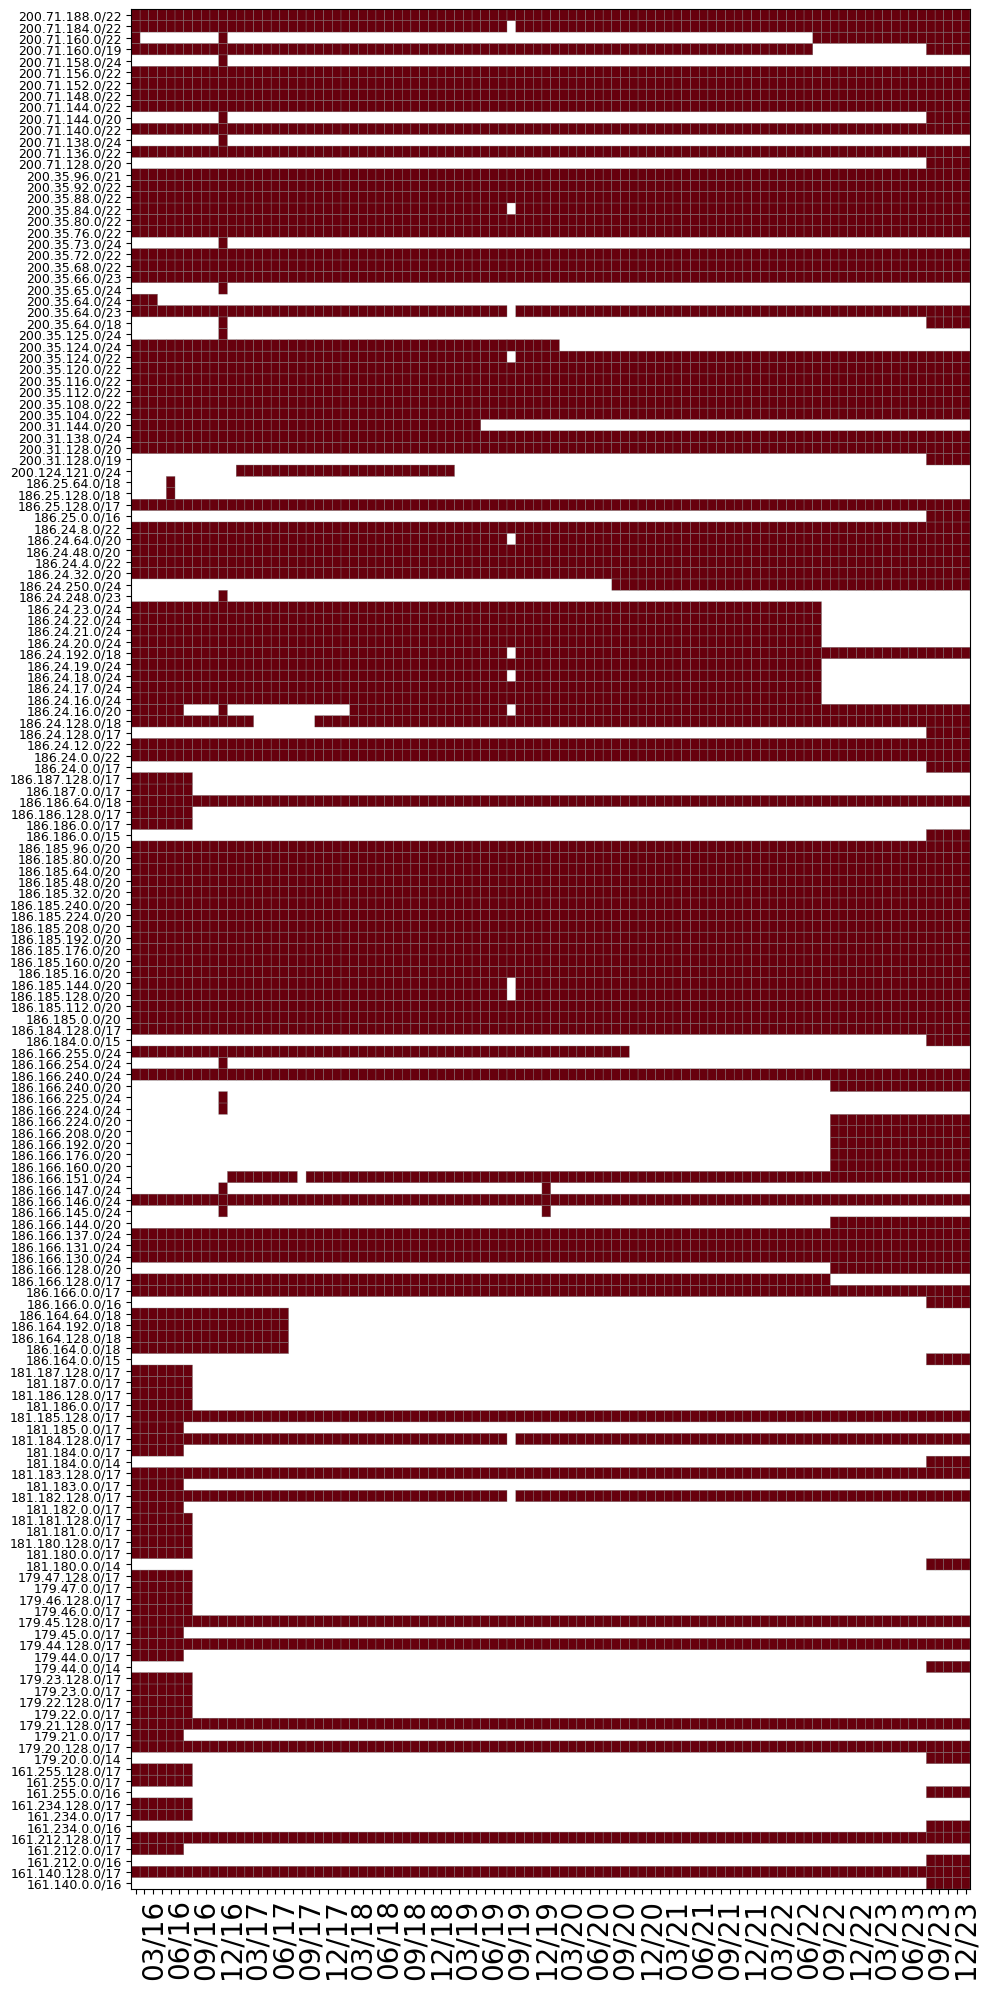

In [16]:
fig, ax = plt.subplots(1, figsize=(10, 20))

p = pfx.pivot(index="pfix", columns="date")["p"]
t = p.columns
idx = p.index
p = p.to_numpy()

heatmap = ax.pcolor(
    p,
    norm=colors.Normalize(vmin=0, vmax=1),
    cmap="Reds",
    edgecolors="grey",
)

ax.set_yticks(np.arange(len(idx)) + 0.5)
ax.set_yticklabels(fontsize=9, labels=idx)

ax.set_xticks(np.arange(len(t)) + 0.5)
ax.set_xticklabels(
    fontsize=20,
    labels=[i.strftime("%m/%y") if i.month % 3 == 0 else "" for i in t],
    rotation=90,
)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig(f"figures/14-telefonica_pfxes_2016_2023.pdf")

In [17]:
start_date = datetime(2016, 1, 1)
end_date = datetime(2024, 1, 1)

pfxes = ["179.44.0.0/17"]

pfx = generate_pfx_dataframe(start_date, end_date, 0, pfxes[0].split("/")[0])

In [18]:
pfx

,origin-asn,pfix,date
361811,6306,179.44.0.0/17,2016-01-01
362551,6306,179.44.0.0/17,2016-02-01
367580,6306,179.44.0.0/17,2016-03-01
373335,6306,179.44.0.0/17,2016-04-01
377363,6306,179.44.0.0/17,2016-05-01
378430,6306,179.44.0.0/17,2016-06-01
634750,6306,179.44.0.0/14,2023-08-01
641864,6306,179.44.0.0/14,2023-09-01
638896,6306,179.44.0.0/14,2023-10-01
638868,6306,179.44.0.0/14,2023-11-01


The heatmap displays all prefixes announced by Telefonica de Venezuela (AS6306) from 2016 to 2024, with colored cells indicating routed prefixes. Our analysis reveals that around June 2016, several /17 prefixes, such as 179.23.128.0, 179.23.0.0, 161.255.0.0, and 161.255.128.0, were no longer visible in our dataset. Interestingly, many of these address blocks reappeared in June 2023, still under Telefonica’s announcement, but now as part of larger address blocks, such as 179.20.0.0/14 and 161.255.128.0/16. The reasons behind Telefonica’s address space contraction during this 7-year period remain unclear; however, it led to a more pro- nounced dominance of CANTV-AS8048 in the domestic address space.
